In [11]:
import pandas as pd
import numpy as np
import regex as re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from yellowbrick.text import PosTagVisualizer
import contractions
import os

In [12]:
# change this line:
work_dir = "/Users/gohyixian/Downloads"

file_path_1 = work_dir + "/NLP-Depression/Dataset/Suicide_Detection.csv"
file_path_2 = work_dir + "/NLP-Depression/Dataset/Normal_Cases.csv"

df1 = pd.read_csv(file_path_1, index_col=None)
df2 = pd.read_csv(file_path_2, index_col=None)

# combine & shuffle
df = pd.concat([df1, df2], axis=0)
df = df.sample(frac=1)

df.head()

,no,text,class
77039,115671.0,Don’t give this any awards If u give me any aw...,non-suicide
2563,3825.0,Putting yourself before others is stupid Ultim...,non-suicide
60061,NaN,do you have any hair styling tips for boys wit...,normal
40234,NaN,im so proud of you girl yas snapfam you seem m...,normal
157714,236619.0,True clarity.The short of it; been seeing a th...,suicide


In [13]:
df_text = df["text"]
df_class =  df["class"]

print(df_text.shape)

(316664,)


In [14]:
print(df_class.shape)

(316664,)


In [15]:
# normal = 0
# non-suicide = 1   (depressed)
# suicide = 2       (depressed)

df_class = df_class.apply(lambda x : "0" if "normal" in str(x) else ("1" if "non-suicide" in str(x) else "2"))

In [16]:
df_class.head()

77039     1
2563      1
60061     0
40234     0
157714    2
Name: class, dtype: object

In [17]:
df = pd.concat([df_text, df_class], axis=1)
print(df.shape)

df.head()

(316664, 2)


,text,class
77039,Don’t give this any awards If u give me any aw...,1
2563,Putting yourself before others is stupid Ultim...,1
60061,do you have any hair styling tips for boys wit...,0
40234,im so proud of you girl yas snapfam you seem m...,0
157714,True clarity.The short of it; been seeing a th...,2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316664 entries, 77039 to 102991
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    316664 non-null  object
 1   class   316664 non-null  object
dtypes: object(2)
memory usage: 7.2+ MB


In [19]:
df = df[df["text"].notna()]
nrow, ncol = df.shape

print(f"There are {nrow} rows & {ncol} columns")

There are 316664 rows & 2 columns


# Pre-Processing
<ul>
    <li>Noise Cleaning - Removing emojis</li>
    <li>Expand contractions</li>
    <li>Remove stopwords</li>
</ul>

In [20]:
# converting emojis to ""
# might take a while..

# white-space split
df["text"] = df["text"].apply(lambda x : [word for word in x.split(" ")])

df["text"] = df["text"].apply(lambda x : [re.sub(r"[^\w\d\s\']+", "", word) for word in x])

emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
    "]+", re.UNICODE)

df["text"] = df["text"].apply(lambda x : [re.sub(emoj, "", word) for word in x])

# Using the encode() function and the decode() function from removing the Unicode characters 
# from the String. Encode() function will encode the string into ‘ASCII’ and error as ‘ignore’ 
# to remove Unicode characters. Decode() function will then decode the string back in its form.
# A short cut to remove emoji variants (🤟🏻🤟🤟🏽🤟🏿) that are not filtered in the above steps
df["text"] = df["text"].apply(lambda x : [word.encode("ascii", "ignore").decode() for word in x])

df["text"] = [' '.join(map(str, word)) for word in df["text"]]

df.head()

,text,class
77039,Dont give this any awards If u give me any awa...,1
2563,Putting yourself before others is stupid Ultim...,1
60061,do you have any hair styling tips for boys wit...,0
40234,im so proud of you girl yas snapfam you seem m...,0
157714,True clarityThe short of it been seeing a ther...,2


In [21]:
# removing rows that are ""

df = df[df["text"] != ""]
print("There are " + str(nrow - df.shape[0]) + " rows that are either empty, containing emojis or ASCII-unencodable and have been removed")
print("Resulting : "+str(df.shape))

There are 13 rows that are either empty, containing emojis or ASCII-unencodable and have been removed
Resulting : (316651, 2)


In [22]:
# expanding contractions
# this line might take some time to run..

df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda x : [contractions.fix(word) for word in x.split(" ")])
df["text"] = [' '.join(map(str, l)) for l in df["text"]]

df.head()

,text,class
77039,do not give this any awards if you give me any...,1
2563,putting yourself before others is stupid ultim...,1
60061,do you have any hair styling tips for boys wit...,0
40234,i am so proud of you girl yas snapfam you seem...,0
157714,true claritythe short of it been seeing a ther...,2


In [23]:
# word tokenization
# this line too might take some time to run...

from nltk.tokenize import word_tokenize
df["text_tokenize"] = df["text"].apply(word_tokenize)

df.head()

,text,class,text_tokenize
77039,do not give this any awards if you give me any...,1,"[do, not, give, this, any, awards, if, you, gi..."
2563,putting yourself before others is stupid ultim...,1,"[putting, yourself, before, others, is, stupid..."
60061,do you have any hair styling tips for boys wit...,0,"[do, you, have, any, hair, styling, tips, for,..."
40234,i am so proud of you girl yas snapfam you seem...,0,"[i, am, so, proud, of, you, girl, yas, snapfam..."
157714,true claritythe short of it been seeing a ther...,2,"[true, claritythe, short, of, it, been, seeing..."


In [24]:
# removing stopwords & numbers
# this too might take some time..

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

df["text_tokenize"] = df["text_tokenize"].apply(lambda x : [word for word in x if word not in stopwords])
df["text_tokenize"] = df["text_tokenize"].apply(lambda x : [word for word in x if not word.isdigit()])
df["text_join"] = [' '.join(map(str, l)) for l in df["text_tokenize"]]

df.head()

,text,class,text_tokenize,text_join
77039,do not give this any awards if you give me any...,1,"[give, awards, give, awards, ill, kiss, cat, l...",give awards give awards ill kiss cat lips bett...
2563,putting yourself before others is stupid ultim...,1,"[putting, others, stupid, ultimately, matters,...",putting others stupid ultimately matters sure ...
60061,do you have any hair styling tips for boys wit...,0,"[hair, styling, tips, boys, receding, hairplea...",hair styling tips boys receding hairpleasei ex...
40234,i am so proud of you girl yas snapfam you seem...,0,"[proud, girl, yas, snapfam, seem, nervous, chi...",proud girl yas snapfam seem nervous chicken be...
157714,true claritythe short of it been seeing a ther...,2,"[true, claritythe, short, seeing, therapist, t...",true claritythe short seeing therapist taking ...


<AxesSubplot:xlabel='class', ylabel='count'>

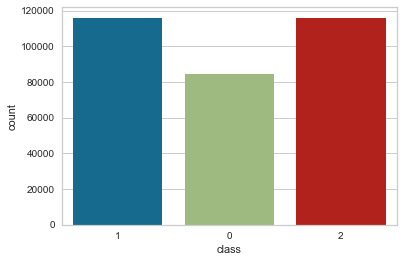

In [25]:
sns.countplot(x = df["class"])

In [26]:
df["class"].value_counts()

1    116037
2    116033
0     84581
Name: class, dtype: int64

In [27]:
# Sampling from data

# Training data from Suicide_Detection.csv contains a lot of sarcasm
# For example, "What a good day today, heck lot of assignments!" (Depression)

# Positive words like "Happy","Good Day","Good Morning" are being labelled
# as words od depression. Thus to overcome it, we will train the model on 
# training data with ratio (Normal : Depressed : Suicidal) = (3:1:1),
# making the model biased towards the "Normal" class, thus balancing out
# the effects from sarcasm.

# Original data for class "1" & "2", 100,000 for each classification category.

df_0 = df[df["class"] == "0"].sample(frac=1.00)  # 100% out of 84,000
df_1 = df[df["class"] == "1"].sample(frac=0.25)  # 25% out of 116000 ~= 29000
df_2 = df[df["class"] == "2"].sample(frac=0.25)  # 25% out of 116000 ~= 29000

df = pd.concat([df_0, df_1, df_2], axis=0)
# use sample (fraction=1.0) (all) to shuffle data
df = df.sample(frac=1)

print(df.shape)

(142598, 4)


In [28]:
df.head()

,text,class,text_tokenize,text_join
14564,best methodi live in the uk so i have no acces...,2,"[best, methodi, live, uk, access, firearms, so...",best methodi live uk access firearms someone t...
68358,a relieving update i have enough oxycodone to ...,2,"[relieving, update, enough, oxycodone, overdos...",relieving update enough oxycodone overdose goi...
15876,i need a wayi need a fucking way to die becaus...,2,"[need, wayi, need, fucking, way, die, pussy, c...",need wayi need fucking way die pussy cut death...
134933,i know i need to redo this i have this really ...,1,"[know, need, redo, really, big, project, scien...",know need redo really big project science basi...
38356,i can finally post i can finally post on rteen...,1,"[finally, post, finally, post, rteenagers, wou...",finally post finally post rteenagers would lik...


# Visualizing Data


In [29]:
# visualize stopwords

%matplotlib inline
def plot_top_stopwords(txt, stopwords):
    new = txt.str.split(" ")
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    dic = dict()
    for word in corpus:
        if word in stopwords:
            dic[str(word)] = dic.get(str(word), 0) + 1
    
    # top 10
    top = sorted(dic.items(), key = lambda x : x[1], reverse=True)[:10]
    
    # unzip items
    x, y = zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x, y)

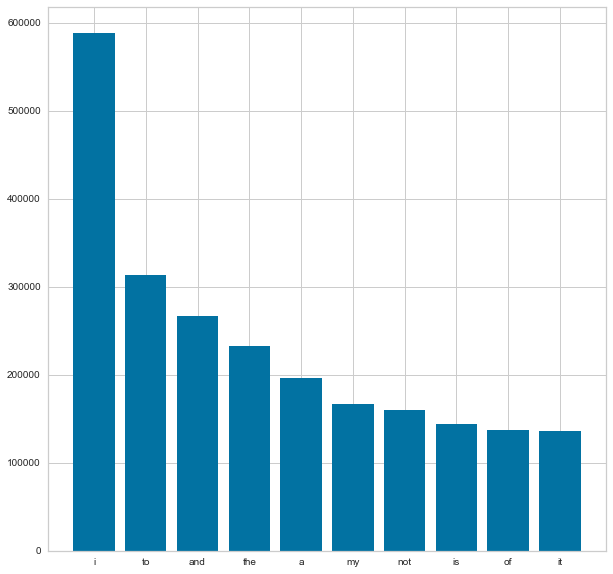

In [30]:
# might take some time..

# *uncleaned data
plot_top_stopwords(df["text"], stopwords)

In [31]:
import seaborn as sns
from collections import Counter

def plot_top_non_stopwords(txt, stopwords):
    new = txt.str.split(" ")
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:200]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
    
    plt.figure(figsize = (15, 30))
    sns.barplot(x=y, y=x)
    

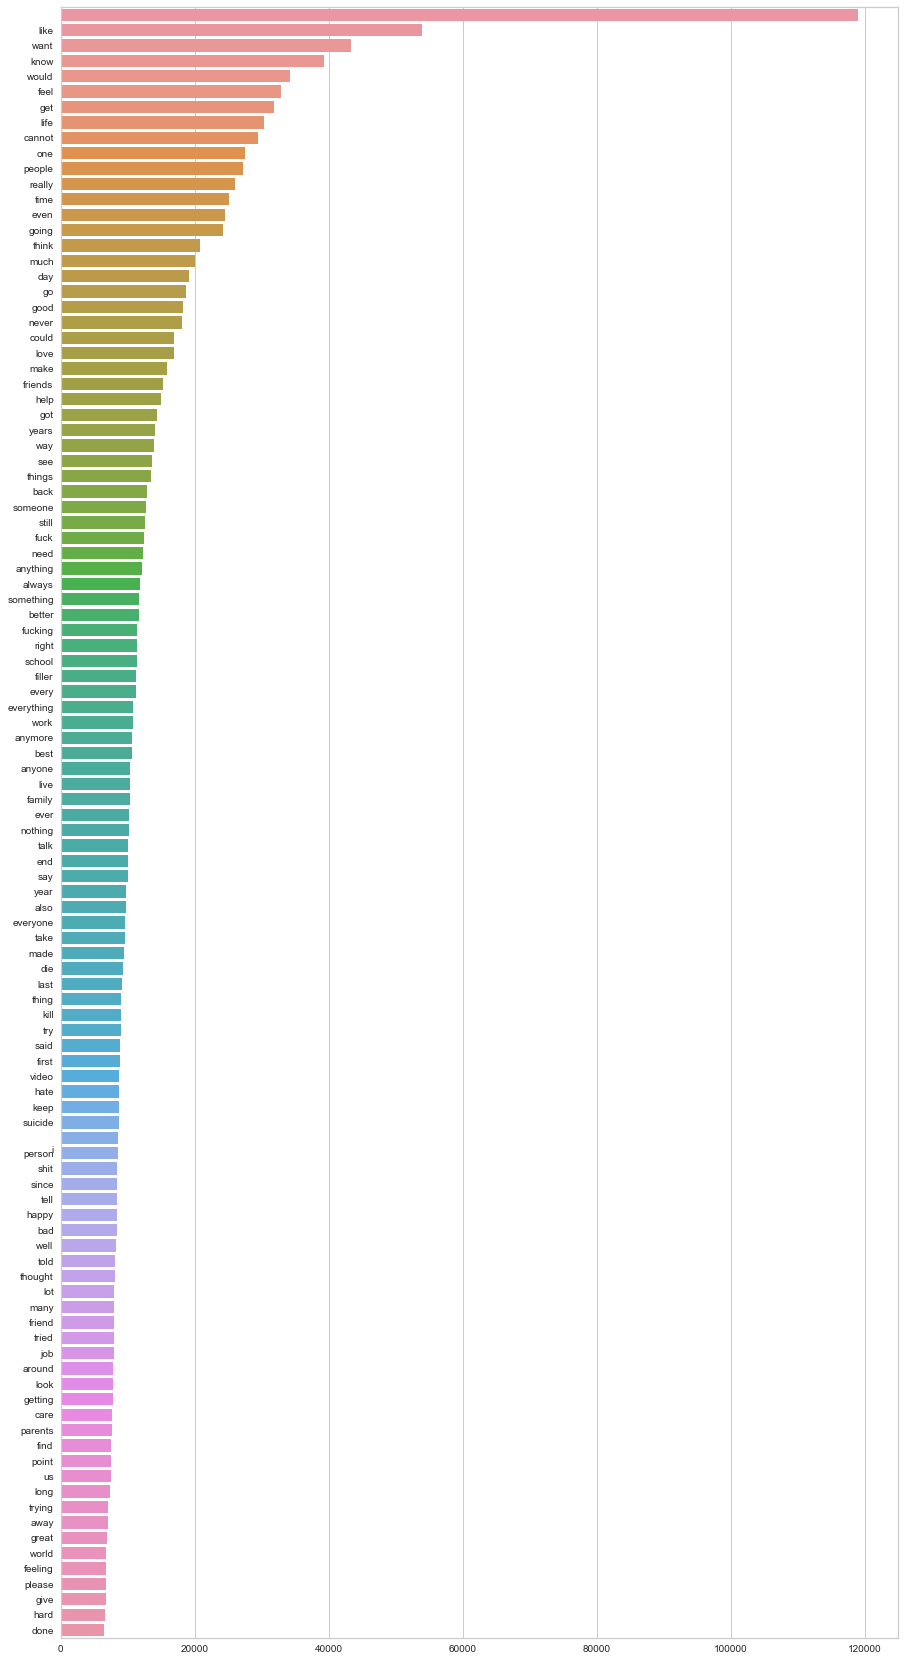

In [32]:
# might take some time..

# *uncleaned data
plot_top_non_stopwords(df["text"], stopwords)

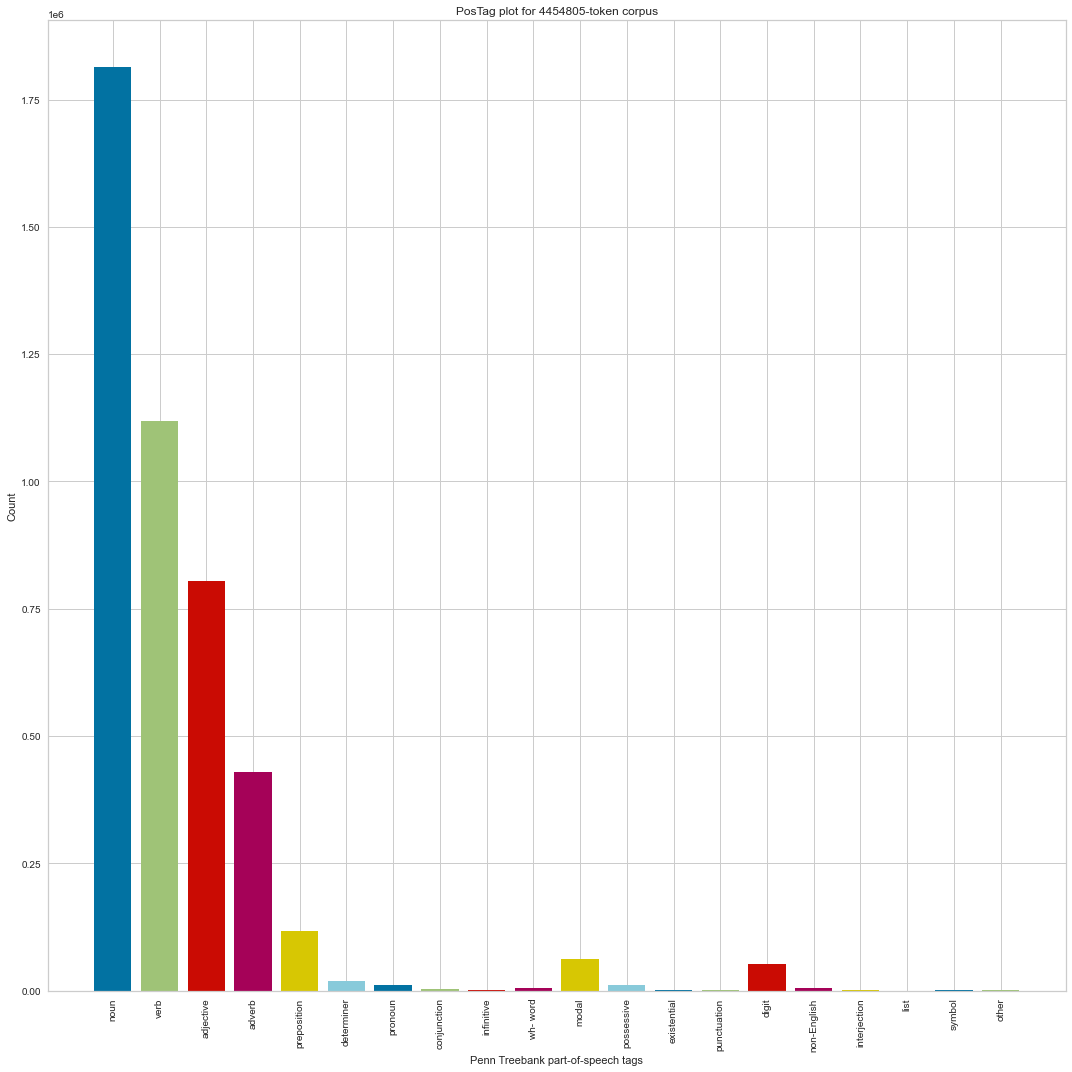

<AxesSubplot:title={'center':'PosTag plot for 4454805-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [33]:
# visualize POS tags (part of speech tagging)
# might take more time to run..

tagged_stanzas_df = []
tagged_df = []

for word in df["text_tokenize"]:
    tagged_word = nltk.pos_tag(word)
    tagged_stanzas_df.append(tagged_word)
    
# create this format for yellowbrick visualizer. It only takes 2 values.
tagged_df.append(tagged_stanzas_df)


from yellowbrick.text import PosTagVisualizer

plt.figure(figsize=(15, 15))
viz = PosTagVisualizer()
viz.fit(tagged_df)
viz.show()

In [34]:
# visualize labels

df["class"].value_counts()

0    84581
1    29009
2    29008
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

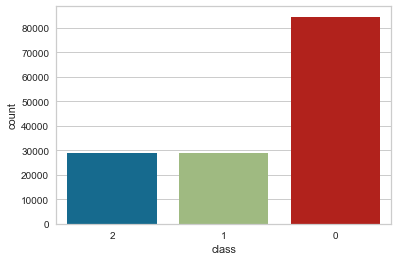

In [35]:
sns.countplot(x = df["class"])

# Exporting Data to CSV

In [39]:
from pathlib import Path

# Here, we sample 0.8 as training data, the other 0.2 as validation data
# During training, we will again split the training data into 0.8 training, 0.2 testing
# This gives us roughly 0.64 training, 0.16 testing, 0.2 validation data

export_dir_train = work_dir + "/NLP-Depression/Dataset/training_data.csv"
export_dir_val = work_dir + "/NLP-Depression/Dataset/validation_data.csv"

# since total = 142598
# 0.8 = 114078
# 0.2 = 28520
df_train = df.head(114078)
df_val = df.tail(28520)

df_train = pd.DataFrame(df_train)
df_train.to_csv(path_or_buf=Path(export_dir_train), 
                sep=",", 
                na_rep="", 
                columns=["text_join", "class"], 
                index=False)

df_val = pd.DataFrame(df_val)
df_val.to_csv(path_or_buf=Path(export_dir_val), 
              sep=",", 
              na_rep="", 
              columns=["text_join", "class"], 
              index=False)
print("OK")

OK
